# 시작

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import Model
from tensorflow.keras.layers import Conv2D, BatchNormalization, ReLU,\
                                    Add, Input, Dense, MaxPooling2D, AveragePooling2D, Flatten
import matplotlib.pyplot as plt

# 데이터 로드 & 이미지 전처리 함수

In [2]:
def normalize_and_resize_img(image, label, shape):
    image = tf.image.resize(image, shape)
    return tf.cast(image, tf.float32) / 255., label

def apply_normalize_on_dataset(ds, batch_size, shape, is_test=False):
    ds = ds.map(lambda image,label:normalize_and_resize_img(image,label,shape)).batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

# 모델 생성

In [3]:
def build_block34(inputs, n_channel, top_layer=False, top_block=False, plain=False, name=''):
    '''
    ResNet34에 사용하는 블럭은 2개의 Conv2D로 이루어진다
    최상단 블럭은 레이어마다 다른 처리가 필요하다
    '''
    if top_block:  # 최상단 블럭
        if top_layer: # 최상단 레이어: 2번 레이어는 MaxPooling 통과 후 identity를 연결한다
            outputs = MaxPooling2D((3,3), strides=2, padding='same', name=f'{name}')(inputs)
            inputs = outputs
            outputs = Conv2D(n_channel, (3,3), padding='same', name=f'{name}_first')(outputs)
        else: # 아래 레이어들: 3,4,5번 레이어는 Conv2D를 통해 크기를 절반으로 줄여 identity를 연결한다
            outputs = Conv2D(n_channel, (3,3), padding='same', strides=2, name=f'{name}_first')(inputs)
            inputs = Conv2D(n_channel, (1,1), padding='same', strides=2, name=f'{name}_half_identity')(inputs)
            inputs = BatchNormalization(name=f'{name}_half_batch')(inputs)
    else: # 아래 블럭들
        outputs = Conv2D(n_channel, (3,3), padding='same', name=f'{name}_first')(inputs)
    outputs = BatchNormalization(name=f'{name}_first_batch')(outputs)
    outputs = ReLU(name=f'{name}_first_relu')(outputs)
    
    # 두번째 Conv2D
    outputs = Conv2D(n_channel, (3,3), padding='same', name=f'{name}_second')(outputs)
    outputs = BatchNormalization(name=f'{name}_second_batch')(outputs)
    
    if not plain: # Ablation을 위한 처리
        outputs = Add(name=f'{name}_add')([inputs,outputs])
    return ReLU(name=f'{name}_relu')(outputs)


def build_block50(inputs, n_channel, top_layer=False, top_block=False, plain=False, name=''):
    '''
    ResNet50에 사용하는 블럭은 3개의 Conv2D로 이루어진다
    최상단 블럭은 레이어마다 다른 처리가 필요하다
    n_channel은 입력 채널의 1/4임을 주의해야한다(2번째 레이어만 입력 채널과 동일)
    '''
    if top_block:  # 최상단 블럭
        if top_layer:  # 최상단 레이어: 2번 레이어는 MaxPooling을 통과 후 Conv2D를 통해 channel을 늘려 연결한다
            outputs = MaxPooling2D((3,3), strides=2, padding='same', name=f'{name}')(inputs)
            inputs = Conv2D(n_channel*4, (1,1), padding='same', name=f'{name}_change_channel')(outputs)
            inputs = BatchNormalization(name=f'{name}_change_channel_batch')(inputs)
            outputs = Conv2D(n_channel, (1,1), padding='same', name=f'{name}_first')(outputs)
        else:  # 아래 레이어들: 3,4,5번 레이어는 Conv2D를 통해 채널을 유지(4배인 상태)하고 identity를 연결한다
            outputs = Conv2D(n_channel, (1,1), padding='same', strides=2, name=f'{name}_first')(inputs)
            inputs = Conv2D(n_channel*4, (1,1), padding='same', strides=2, name=f'{name}_half_identity')(inputs)
            inputs = BatchNormalization(name=f'{name}_half_batch')(inputs)
    else: # 아래 블럭들
        outputs = Conv2D(n_channel, (1,1), padding='same', name=f'{name}_first')(inputs)
    outputs = BatchNormalization(name=f'{name}_first_batch')(outputs)
    outputs = ReLU(name=f'{name}_first_relu')(outputs)
    
    # 두번째 Conv2D
    outputs = Conv2D(n_channel, (3,3), padding='same', name=f'{name}_second')(outputs)
    outputs = BatchNormalization(name=f'{name}_second_batch')(outputs)
    outputs = ReLU(name=f'{name}_second_relu')(outputs)
    
    # 세번째 Conv2D
    outputs = Conv2D(n_channel*4, (1,1), padding='same', name=f'{name}_third')(outputs)
    outputs = BatchNormalization(name=f'{name}_third_batch')(outputs)
    
    if not plain: # Ablation을 위한 처리
        outputs = Add(name=f'{name}_add')([inputs,outputs])
    return ReLU(name=f'{name}_relu')(outputs)


def build_resnet(mode, input_shape=(32,32,3), n_class=10, blocks=[3,4,6,3], plain=False):
    '''
    ResNet모델을 생성한다
    
    mode: 34 또는 50
    '''
    channel = 64
    inputs = Input(input_shape)
    
    # 1번 레이어
    hiddens = Conv2D(channel, (7,7), strides=2, padding='same', name='conv1')(inputs)
    hiddens = BatchNormalization(name='conv1_batch')(hiddens)
    hiddens = ReLU(name='conv1_relu')(hiddens)
    
    # 2번~5번 레이어
    for i_layer, block in enumerate(blocks, start=2):
        for i_block in range(1, block+1):
            if mode==34:
                hiddens = build_block34(hiddens, channel, (i_layer==2), (i_block==1), plain, f'conv{i_layer}_{i_block}')
            elif mode==50:
                hiddens = build_block50(hiddens, channel, (i_layer==2), (i_block==1), plain, f'conv{i_layer}_{i_block}')
        channel *= 2
        
    # FC 레이어
    outputs = AveragePooling2D((1,1), name='average_pooling')(hiddens)
    outputs = Flatten()(outputs)
    outputs = Dense(n_class, activation='softmax', name=f'fc_{n_class}')(outputs)
    return Model(inputs=inputs, outputs=outputs)

# 모델 훈련 & 결과

In [4]:
BATCH_SIZE = 16
EPOCH = 10

def train_model(model, ds_train, ds_test, n_train, n_test, shape=[32,32]):
    model.compile(
        loss='sparse_categorical_crossentropy',
        optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
        metrics=['accuracy']
    )
    return model.fit(
        apply_normalize_on_dataset(ds_train, BATCH_SIZE, shape),
        steps_per_epoch=int(n_train/BATCH_SIZE),
        validation_steps=int(n_test/BATCH_SIZE),
        epochs=EPOCH,
        validation_data=apply_normalize_on_dataset(ds_test, BATCH_SIZE, shape, is_test=True),
        verbose=1,
        use_multiprocessing=True
    )

In [5]:
def draw_history(names, histories):
    plt.title('val accuracy')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    for history in histories:
        plt.plot(history['val_accuracy'])
    plt.legend(names)
    plt.show()
    
    plt.title('val loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    for history in histories:
        plt.plot(history['val_loss'])
    plt.legend(names)
    plt.show()

# 메인

## CIFAR-10 (32,32,3)

In [6]:
(ds_train, ds_test), ds_info = tfds.load('cifar10', split=['train', 'test'], as_supervised=True, shuffle_files=True, with_info=True)
n_train = ds_info.splits['train'].num_examples
n_test = ds_info.splits['test'].num_examples

## ResNet 34 vs Plain 34

In [7]:
resnet_34 = build_resnet(34)
resnet_34.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 16, 16, 64)   9472        input_1[0][0]                    
__________________________________________________________________________________________________
conv1_batch (BatchNormalization (None, 16, 16, 64)   256         conv1[0][0]                      
__________________________________________________________________________________________________
conv1_relu (ReLU)               (None, 16, 16, 64)   0           conv1_batch[0][0]                
______________________________________________________________________________________________

In [8]:
plain_34 = build_resnet(34, plain=True)
plain_34.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 16, 16, 64)        9472      
_________________________________________________________________
conv1_batch (BatchNormalizat (None, 16, 16, 64)        256       
_________________________________________________________________
conv1_relu (ReLU)            (None, 16, 16, 64)        0         
_________________________________________________________________
conv2_1 (MaxPooling2D)       (None, 8, 8, 64)          0         
_________________________________________________________________
conv2_1_first (Conv2D)       (None, 8, 8, 64)          36928     
_________________________________________________________________
conv2_1_first_batch (BatchNo (None, 8, 8, 64)          256 

In [9]:
history_resnet_34 = train_model(resnet_34, ds_train, ds_test, n_train, n_test)

Epoch 1/10
3125/3125 [==============================] - 79s 25ms/step - loss: 2.0492 - accuracy: 0.3002 - val_loss: 1.6224 - val_accuracy: 0.4124
Epoch 2/10
3125/3125 [==============================] - 79s 25ms/step - loss: 1.4729 - accuracy: 0.4752 - val_loss: 1.3452 - val_accuracy: 0.5233
Epoch 3/10
3125/3125 [==============================] - 80s 26ms/step - loss: 1.2149 - accuracy: 0.5728 - val_loss: 1.3833 - val_accuracy: 0.5262
Epoch 4/10
3125/3125 [==============================] - 80s 26ms/step - loss: 1.0431 - accuracy: 0.6352 - val_loss: 1.1109 - val_accuracy: 0.6142
Epoch 5/10
3125/3125 [==============================] - 81s 26ms/step - loss: 0.9091 - accuracy: 0.6822 - val_loss: 1.1010 - val_accuracy: 0.6203
Epoch 6/10
3125/3125 [==============================] - 81s 26ms/step - loss: 0.8036 - accuracy: 0.7203 - val_loss: 1.0319 - val_accuracy: 0.6413
Epoch 7/10
3125/3125 [==============================] - 81s 26ms/step - loss: 0.6939 - accuracy: 0.7583 - val_loss: 1.0420 -

In [10]:
history_plain_34 = train_model(plain_34, ds_train, ds_test, n_train, n_test)

Epoch 1/10
3125/3125 [==============================] - 77s 25ms/step - loss: 2.2414 - accuracy: 0.1668 - val_loss: 1.9430 - val_accuracy: 0.2749
Epoch 2/10
3125/3125 [==============================] - 77s 25ms/step - loss: 1.7471 - accuracy: 0.3530 - val_loss: 1.5868 - val_accuracy: 0.4260
Epoch 3/10
3125/3125 [==============================] - 77s 25ms/step - loss: 1.5498 - accuracy: 0.4394 - val_loss: 1.5342 - val_accuracy: 0.4405
Epoch 4/10
3125/3125 [==============================] - 77s 25ms/step - loss: 1.3925 - accuracy: 0.5078 - val_loss: 1.3358 - val_accuracy: 0.5320
Epoch 5/10
3125/3125 [==============================] - 77s 25ms/step - loss: 1.2677 - accuracy: 0.5561 - val_loss: 1.4389 - val_accuracy: 0.4969
Epoch 6/10
3125/3125 [==============================] - 77s 25ms/step - loss: 1.1771 - accuracy: 0.5914 - val_loss: 1.3170 - val_accuracy: 0.5357
Epoch 7/10
3125/3125 [==============================] - 77s 25ms/step - loss: 1.0785 - accuracy: 0.6301 - val_loss: 1.1334 -

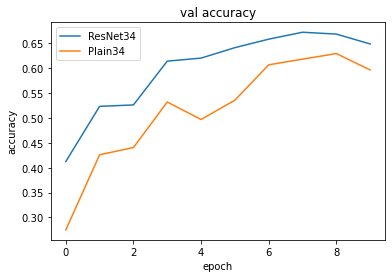

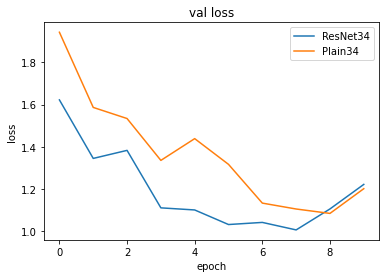

In [11]:
draw_history(['ResNet34', 'Plain34'], [history_resnet_34.history, history_plain_34.history])

## ResNet 50 vs Plain 50

In [12]:
resnet_50 = build_resnet(50)
resnet_50.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 16, 16, 64)   9472        input_3[0][0]                    
__________________________________________________________________________________________________
conv1_batch (BatchNormalization (None, 16, 16, 64)   256         conv1[0][0]                      
__________________________________________________________________________________________________
conv1_relu (ReLU)               (None, 16, 16, 64)   0           conv1_batch[0][0]                
____________________________________________________________________________________________

In [13]:
plain_50 = build_resnet(50, plain=True)
plain_50.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 16, 16, 64)        9472      
_________________________________________________________________
conv1_batch (BatchNormalizat (None, 16, 16, 64)        256       
_________________________________________________________________
conv1_relu (ReLU)            (None, 16, 16, 64)        0         
_________________________________________________________________
conv2_1 (MaxPooling2D)       (None, 8, 8, 64)          0         
_________________________________________________________________
conv2_1_first (Conv2D)       (None, 8, 8, 64)          4160      
_________________________________________________________________
conv2_1_first_batch (BatchNo (None, 8, 8, 64)          256 

In [14]:
history_resnet_50 = train_model(resnet_50, ds_train, ds_test, n_train, n_test)

Epoch 1/10
3125/3125 [==============================] - 91s 29ms/step - loss: 2.6441 - accuracy: 0.1546 - val_loss: 2.4395 - val_accuracy: 0.1832
Epoch 2/10
3125/3125 [==============================] - 91s 29ms/step - loss: 2.2069 - accuracy: 0.2255 - val_loss: 2.7750 - val_accuracy: 0.2730
Epoch 3/10
3125/3125 [==============================] - 91s 29ms/step - loss: 1.8937 - accuracy: 0.3225 - val_loss: 2.0103 - val_accuracy: 0.3630
Epoch 4/10
3125/3125 [==============================] - 91s 29ms/step - loss: 1.6487 - accuracy: 0.4078 - val_loss: 1.5235 - val_accuracy: 0.4584
Epoch 5/10
3125/3125 [==============================] - 91s 29ms/step - loss: 1.4805 - accuracy: 0.4756 - val_loss: 1.6683 - val_accuracy: 0.4895
Epoch 6/10
3125/3125 [==============================] - 91s 29ms/step - loss: 1.3371 - accuracy: 0.5288 - val_loss: 1.4394 - val_accuracy: 0.5246
Epoch 7/10
3125/3125 [==============================] - 91s 29ms/step - loss: 1.2045 - accuracy: 0.5777 - val_loss: 1.2198 -

In [15]:
history_plain_50 = train_model(plain_50, ds_train, ds_test, n_train, n_test)

Epoch 1/10
3125/3125 [==============================] - 83s 26ms/step - loss: 2.4473 - accuracy: 0.1068 - val_loss: 4.5999 - val_accuracy: 0.1142
Epoch 2/10
3125/3125 [==============================] - 82s 26ms/step - loss: 2.3648 - accuracy: 0.1080 - val_loss: 3.8504 - val_accuracy: 0.1119
Epoch 3/10
3125/3125 [==============================] - 82s 26ms/step - loss: 2.3364 - accuracy: 0.1074 - val_loss: 2.6842 - val_accuracy: 0.1175
Epoch 4/10
3125/3125 [==============================] - 84s 27ms/step - loss: 2.1818 - accuracy: 0.1745 - val_loss: 2.7682 - val_accuracy: 0.2466
Epoch 5/10
3125/3125 [==============================] - 82s 26ms/step - loss: 1.9317 - accuracy: 0.2805 - val_loss: 1.7851 - val_accuracy: 0.3493
Epoch 6/10
3125/3125 [==============================] - 82s 26ms/step - loss: 1.7513 - accuracy: 0.3604 - val_loss: 1.6862 - val_accuracy: 0.3827
Epoch 7/10
3125/3125 [==============================] - 82s 26ms/step - loss: 1.6272 - accuracy: 0.4102 - val_loss: 2.3332 -

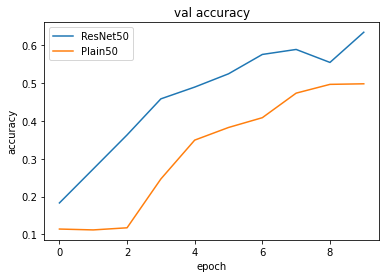

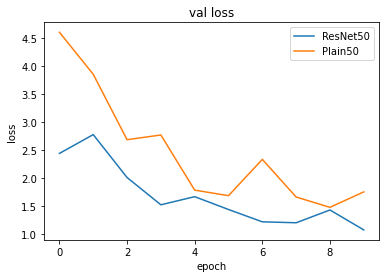

In [16]:
draw_history(['ResNet50', 'Plain50'],[history_resnet_50.history, history_plain_50.history])

## cats_vs_dogs (224, 224, 3)

In [17]:
(ds_train, ds_test), ds_info = tfds.load('cats_vs_dogs', split=[
    tfds.Split.TRAIN.subsplit(tfds.percent[:80]),
    tfds.Split.TRAIN.subsplit(tfds.percent[80:]),
], as_supervised=True, shuffle_files=True, with_info=True)
n_train = ds_info.splits['train'].num_examples * 0.8
n_test = ds_info.splits['train'].num_examples * 0.2

## ResNet 34 vs Plain 34

In [18]:
resnet_34 = build_resnet(34, input_shape=(224,224,3), n_class=2)
resnet_34.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        input_5[0][0]                    
__________________________________________________________________________________________________
conv1_batch (BatchNormalization (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
conv1_relu (ReLU)               (None, 112, 112, 64) 0           conv1_batch[0][0]                
____________________________________________________________________________________________

In [19]:
plain_34 = build_resnet(34, input_shape=(224,224,3), n_class=2, plain=True)
plain_34.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 64)      9472      
_________________________________________________________________
conv1_batch (BatchNormalizat (None, 112, 112, 64)      256       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 64)      0         
_________________________________________________________________
conv2_1 (MaxPooling2D)       (None, 56, 56, 64)        0         
_________________________________________________________________
conv2_1_first (Conv2D)       (None, 56, 56, 64)        36928     
_________________________________________________________________
conv2_1_first_batch (BatchNo (None, 56, 56, 64)        256 

In [20]:
history_resnet_34 = train_model(resnet_34, ds_train, ds_test, n_train, n_test, shape=[224,224])

Epoch 1/10
1163/1163 [==============================] - 134s 115ms/step - loss: 1.1061 - accuracy: 0.5595 - val_loss: 1.1519 - val_accuracy: 0.5778
Epoch 2/10
1163/1163 [==============================] - 95s 81ms/step - loss: 0.9950 - accuracy: 0.5836 - val_loss: 1.0128 - val_accuracy: 0.5830
Epoch 3/10
1163/1163 [==============================] - 95s 82ms/step - loss: 0.8836 - accuracy: 0.6271 - val_loss: 1.1434 - val_accuracy: 0.5983
Epoch 4/10
1163/1163 [==============================] - 95s 82ms/step - loss: 0.7594 - accuracy: 0.6769 - val_loss: 4.5046 - val_accuracy: 0.5582
Epoch 5/10
1163/1163 [==============================] - 95s 82ms/step - loss: 0.6783 - accuracy: 0.7032 - val_loss: 0.7192 - val_accuracy: 0.7039
Epoch 6/10
1163/1163 [==============================] - 95s 82ms/step - loss: 0.5759 - accuracy: 0.7579 - val_loss: 1.2212 - val_accuracy: 0.6841
Epoch 7/10
1163/1163 [==============================] - 95s 82ms/step - loss: 0.4736 - accuracy: 0.8005 - val_loss: 0.7624

In [21]:
history_plain_34 = train_model(plain_34, ds_train, ds_test, n_train, n_test, shape=[224,224])

Epoch 1/10
1163/1163 [==============================] - 91s 78ms/step - loss: 0.8365 - accuracy: 0.5106 - val_loss: 1.6987 - val_accuracy: 0.5110
Epoch 2/10
1163/1163 [==============================] - 91s 78ms/step - loss: 0.8261 - accuracy: 0.5178 - val_loss: 3.4259 - val_accuracy: 0.5519
Epoch 3/10
1163/1163 [==============================] - 91s 78ms/step - loss: 0.7996 - accuracy: 0.5202 - val_loss: 0.7079 - val_accuracy: 0.5397
Epoch 4/10
1163/1163 [==============================] - 91s 78ms/step - loss: 0.7842 - accuracy: 0.5361 - val_loss: 1.8106 - val_accuracy: 0.5974
Epoch 5/10
1163/1163 [==============================] - 91s 78ms/step - loss: 0.7331 - accuracy: 0.6076 - val_loss: 0.6493 - val_accuracy: 0.6407
Epoch 6/10
1163/1163 [==============================] - 91s 78ms/step - loss: 0.6899 - accuracy: 0.6497 - val_loss: 0.7608 - val_accuracy: 0.6433
Epoch 7/10
1163/1163 [==============================] - 91s 78ms/step - loss: 0.6472 - accuracy: 0.6870 - val_loss: 0.8159 -

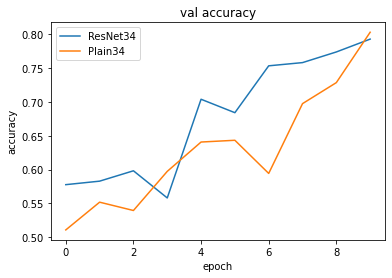

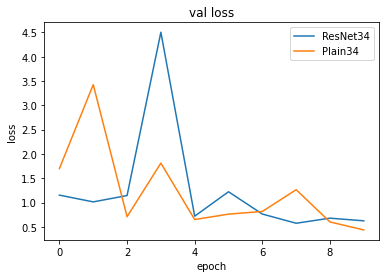

In [22]:
draw_history(['ResNet34', 'Plain34'], [history_resnet_34.history, history_plain_34.history])

In [23]:
resnet_50 = build_resnet(50, input_shape=(224,224,3), n_class=2)
resnet_50.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        input_7[0][0]                    
__________________________________________________________________________________________________
conv1_batch (BatchNormalization (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
conv1_relu (ReLU)               (None, 112, 112, 64) 0           conv1_batch[0][0]                
____________________________________________________________________________________________

In [24]:
plain_50 = build_resnet(50, input_shape=(224,224,3), n_class=2, plain=True)
plain_50.summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 64)      9472      
_________________________________________________________________
conv1_batch (BatchNormalizat (None, 112, 112, 64)      256       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 64)      0         
_________________________________________________________________
conv2_1 (MaxPooling2D)       (None, 56, 56, 64)        0         
_________________________________________________________________
conv2_1_first (Conv2D)       (None, 56, 56, 64)        4160      
_________________________________________________________________
conv2_1_first_batch (BatchNo (None, 56, 56, 64)        256 

In [25]:
history_resnet_50 = train_model(resnet_50, ds_train, ds_test, n_train, n_test, shape=[224,224])

Epoch 1/10
1163/1163 [==============================] - 221s 190ms/step - loss: 1.3099 - accuracy: 0.5285 - val_loss: 8.4829 - val_accuracy: 0.5004
Epoch 2/10
1163/1163 [==============================] - 159s 137ms/step - loss: 1.2292 - accuracy: 0.5495 - val_loss: 8.8661 - val_accuracy: 0.4920
Epoch 3/10
1163/1163 [==============================] - 160s 137ms/step - loss: 1.2026 - accuracy: 0.5526 - val_loss: 3.5728 - val_accuracy: 0.5297
Epoch 4/10
1163/1163 [==============================] - 160s 138ms/step - loss: 1.1183 - accuracy: 0.5743 - val_loss: 1.6135 - val_accuracy: 0.5446
Epoch 5/10
1163/1163 [==============================] - 160s 137ms/step - loss: 1.0075 - accuracy: 0.5959 - val_loss: 0.7524 - val_accuracy: 0.6446
Epoch 6/10
1163/1163 [==============================] - 160s 138ms/step - loss: 0.9219 - accuracy: 0.6423 - val_loss: 1.0125 - val_accuracy: 0.5575
Epoch 7/10
1163/1163 [==============================] - 160s 138ms/step - loss: 0.8709 - accuracy: 0.6669 - val_

In [26]:
history_plain_50 = train_model(plain_50, ds_train, ds_test, n_train, n_test, shape=[224,224])

Epoch 1/10
1163/1163 [==============================] - 134s 115ms/step - loss: 0.8718 - accuracy: 0.5214 - val_loss: 5.8248 - val_accuracy: 0.4903
Epoch 2/10
1163/1163 [==============================] - 134s 115ms/step - loss: 0.8826 - accuracy: 0.5169 - val_loss: 2.7186 - val_accuracy: 0.5550
Epoch 3/10
1163/1163 [==============================] - 133s 115ms/step - loss: 0.8790 - accuracy: 0.5224 - val_loss: 0.8424 - val_accuracy: 0.5181
Epoch 4/10
1163/1163 [==============================] - 132s 113ms/step - loss: 0.8986 - accuracy: 0.5224 - val_loss: 0.9717 - val_accuracy: 0.5256
Epoch 5/10
1163/1163 [==============================] - 134s 115ms/step - loss: 0.9014 - accuracy: 0.5149 - val_loss: 1.2010 - val_accuracy: 0.5058
Epoch 6/10
1163/1163 [==============================] - 134s 115ms/step - loss: 0.9019 - accuracy: 0.5102 - val_loss: 6.0786 - val_accuracy: 0.4784
Epoch 7/10
1163/1163 [==============================] - 134s 115ms/step - loss: 0.9064 - accuracy: 0.5053 - val_

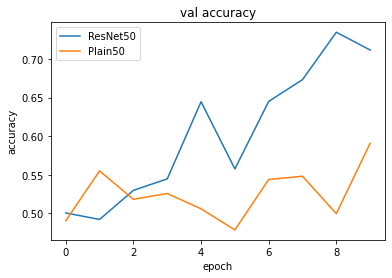

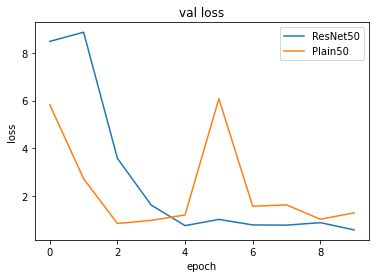

In [27]:
draw_history(['ResNet50', 'Plain50'],[history_resnet_50.history, history_plain_50.history])

# 결론

ResNet구현시 블록의 BatchNormalization과 ReLU의 위치가 지정되어 있지 않으므로, 가장 단순한 Conv2D-BN-ReLU-Conv2D-BN-Add-ReLU 방식을 사용하였다.   
두번째 레이어의 첫 블록의 channel수 지정에 대해서도 논문에 나와있지 않으므로, 추측하여 ResNet50에서만 4배로 증가시켰다.  
  
cats_vs_dogs 이미지는 각각 크기가 다르므로 이미지 크기를 (224,224,3)으로 바꾸는 전처리를 하였다.   
이후 학습 과정에서는 loss와 accuracy가 고르게 감소/증가하지는 않았으나 대체로 감소/증가하였다.  
ResNet이 Plain보다 좋은 결과가 나타나는 것을 뚜렷히 볼 수 있었다.  

만약 epoch수를 늘리고 학습률을 점차 감소 시켜간다면 더 좋은 곡선을 볼 수 있을 것으로 기대된다.  